In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean
import numpy as np
from scipy.stats import linregress
import datetime
import pandas as pd
import plots_spatial as pltspat
# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0
import datesandtime

In [2]:
# Subdomain information (As inputted into TRACMASS, note non-pythonic indexing)
imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_fwd/")

# Location of masks and grid information for the model

# mask_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mask.nc")
# hgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_hgr.nc")
# zgrid_path = os.path.abspath("/gws/nopw/j04/aopp/astyles/TRACMASS_DATA/DRAKKAR_SET/ORCA025/topo/mesh_zgr.nc")

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")

In [3]:
grid_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/topo" )
grid_files = ['mask.nc','mesh_hgr.nc','mesh_zgr.nc']

In [4]:
ds_domain = open_domain_cfg( datadir=grid_path, files = grid_files )

In [5]:
sum_z = np.array(ds_domain.e3t_1d['gdept_1d'])
z_index = np.array(ds_domain.e3t_1d['z_c'])
cell_z = np.append(np.array(da.diff(ds_domain.e3t_1d['gdept_1d'])),0)
df_sum = dd.from_dict({'bin_depth_i':sum_z,'binnedz_i':z_index, 'cell_h':cell_z},npartitions =3)
df_merge = df_vent.merge(df_sum,on = 'binnedz_i')
df_merge['depth_i'] = (df_merge['bin_depth_i'] - da.floor(df_merge['bin_depth_i']))* df_merge['cell_h'] + df_merge['bin_depth_i']


In [21]:
df = df_merge[['year_o','time_o','depth_i','binnedz_i','z_i','bin_depth_i']]

df = df[df['year_o']>1983].compute()

In [7]:
df_merge.head(3)

,ntraj_o,x_o,y_o,z_o,subvol_o,time_o,boxface_o,temp_o,sal_o,density_o,...,dayofyear_o,binnedx_i,binnedy_i,binnedz_i,binnedx_o,binnedy_o,binnedz_o,bin_depth_i,cell_h,depth_i
0,4224,1200.18,334.99,17.85,7.620966e+08,302400.0,0,15.93,35.43,25.96,...,353,1200,335,17,1200,335,18,47.211894,6.638743,48.618604
1,635086,1198.02,319.50,14.50,6.773663e+08,4320.0,0,11.43,34.64,26.29,...,350,1198,319,14,1198,319,14,30.874562,4.865643,35.129867
2,637567,1200.08,296.18,18.49,8.949214e+08,4320.0,0,9.66,34.37,26.39,...,350,1200,296,18,1200,296,18,53.850637,7.262203,60.028137


In [8]:
#df_merge.tail(20)

[]

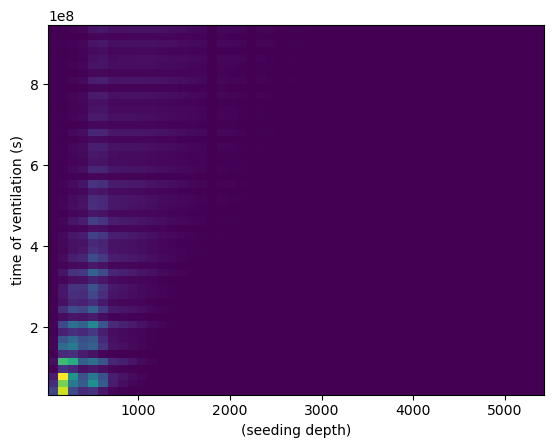

In [26]:
import matplotlib as mpl
plt.hist2d(df.depth_i,df.time_o,bins = (50,50))
plt.xlabel('(seeding depth)')
plt.ylabel('time of ventilation (s)')
#plt.xlim(0,1000)
plt.plot()

[]

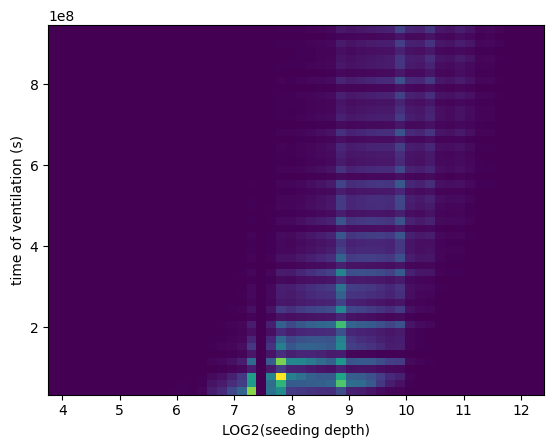

In [25]:
import matplotlib as mpl
plt.hist2d(da.log2(df.depth_i),df.time_o,bins = (50,50),norm=mpl.colors.LogNorm())
plt.xlabel('LOG2(seeding depth)')
plt.ylabel('time of ventilation (s)')
#plt.xlim(0,1000)
plt.plot()

[]

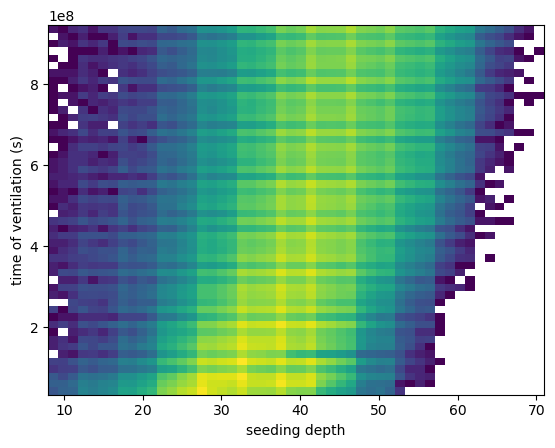

In [30]:
####### Need real depth, not binned depth to get pattern
plt.hist2d(df.binnedz_i,df.time_o,bins = (50,50),norm=mpl.colors.LogNorm())
plt.xlabel('seeding depth')
plt.ylabel('time of ventilation (s)')
plt.plot()

In [20]:
###########

In [21]:
sum_z = np.array(ds_domain.e3t_1d['gdept_1d'])
z_index = np.array(ds_domain.e3t_1d['z_c'])
cell_z = np.append(np.array(da.diff(ds_domain.e3t_1d['gdept_1d'])),0)
df_sum = dd.from_dict({'bin_depth_o':sum_z,'binnedz_o':z_index, 'cell_h':cell_z},npartitions =3)
df_merge = df_vent.merge(df_sum,on = 'binnedz_o')
df_merge['depth_o'] = (df_merge['bin_depth_o'] - da.floor(df_merge['bin_depth_o']))* df_merge['cell_h'] + df_merge['bin_depth_o']


In [23]:
df_finalz = df_merge[['depth_o', 'year_o', 'month_o']]
df_group_z = df_finalz.groupby(['month_o','year_o'])
mean_z = df_group_z.mean()['depth_o'].compute()
mean_z = mean_z.reset_index()
mean_z['date'] = pd.to_datetime( dict(year=mean_z.year_o, month=mean_z.month_o, day=1))
mean_z =mean_z.sort_values('date')
mean_z = mean_z.reset_index()


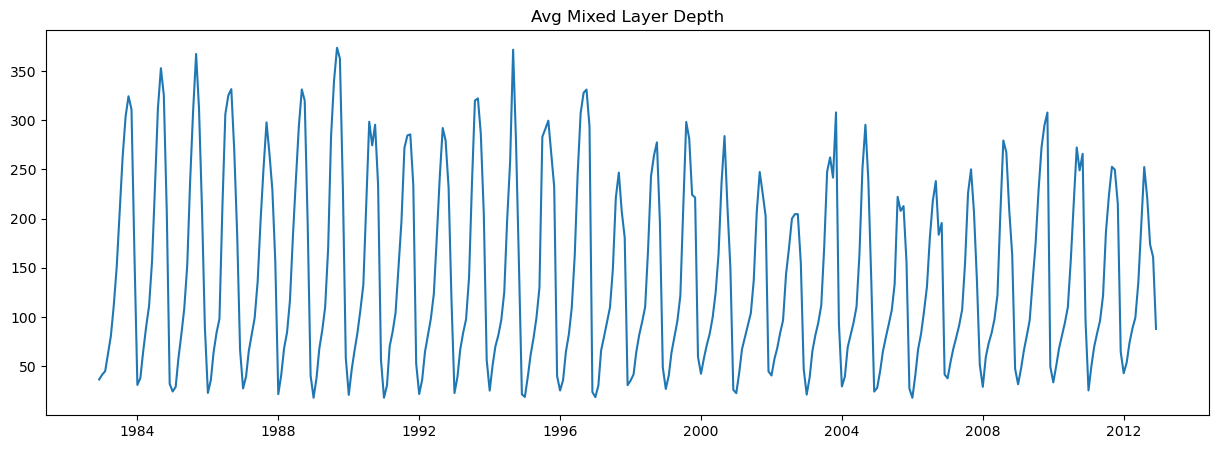

In [24]:
fig = plt.figure(figsize=(15,5))
plt.plot(mean_z.date,mean_z.depth_o)
plt.title('Avg Mixed Layer Depth')
plt.show()